# <center> Literature seminar: XAI </center>

<br>

|<img align="center" width="70" height="70" src="pictures/c-lab.png"> http://www.czodrowskilab.org/|<img align="center" width="70" height="70" src="pictures/twitter.png"> http://twitter.com/czodrowskipaul|
|:--:|:--:|
|<img align="center" width="70" height="70" src="pictures/spotify.png"> http://www.czodrowskilab.org/music|<img align="center" width="70" height="70" src="pictures/github.png"> http://github.com/czodrowskilab|
<br><br>
**Installation details for this paper/code: https://github.com/josejimenezluna/molgrad**

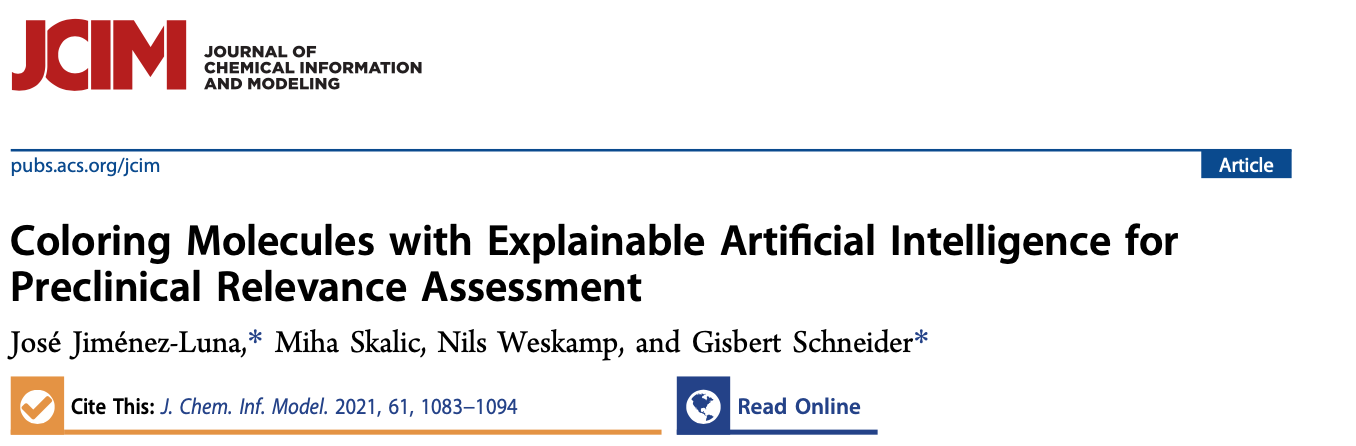

https://pubs.acs.org/doi/10.1021/acs.jcim.0c01344

## Datasets

<center><img src="pictures/data.xai.png"></center>

## Methods
<center>
<img width="40%" height="40%" src="pictures/xai.method001.png">
</center>

<center>
<img width="40%" height="40%" src="pictures/xai.method002.png">
</center>

<center>
<img width="60%" height="60%" src="pictures/xai.method0003.png">
</center>

A visual representation of how the different kinds of information were used to generate the predictions, including latent graph vectors generated via message passing and the vector of calculated global molecular properties, can be found here:
<center>
<img width="74%" height="74%" src="pictures/xai.Figure2.png">
</center>

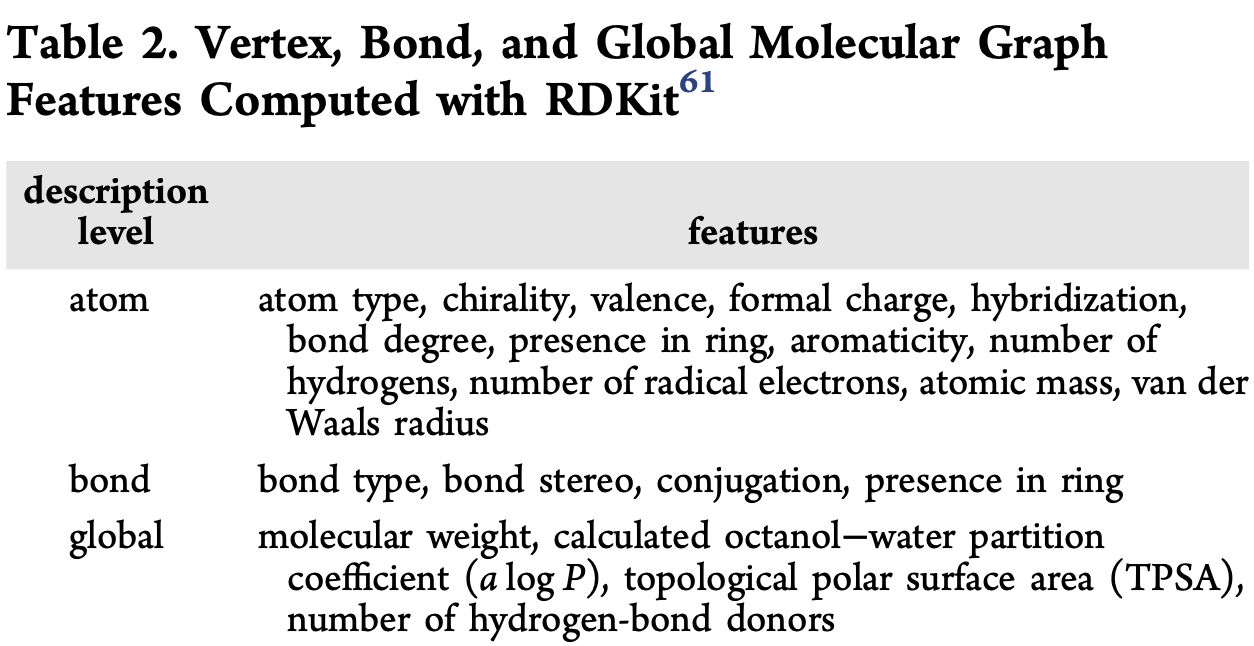

## Model Training

- k = 10 cross-validation schem
- random cross-validation (no split based on scaffold or time)
- For each data split: 250 epochs (batch size of 32 samples)
- Adam stochastic optimizer with default momentum parameters (β1 = 0.9, β2 = 0.999) and a starting learning rate of 10−4.

<br>
<center>
<img width="80%" height="80%" src="pictures/xai.Table3.png">
</center>

# hERG examples from the literature

Introduction of a negative charge leads to hERG potency drop 

https://link.springer.com/chapter/10.1007/7355_2014_38
<br>
<br>
<center>
<img width="80%" height="80%" src="pictures/xai.herg.literatureexamples.png">
</center>

# Python code

So how does the code and the output look like?<br>
In these examples, no pIC50 prediction is performed or at least outputted

In [26]:
import os
os.chdir('../..')
import numpy as np
import pickle
from tqdm import tqdm
from molgrad.vis import molecule_importance
from molgrad.utils import MODELS_PATH, EXAMPLE_PATH
from molgrad.train import DEVICE
from molgrad.prod import predict_mol
from rdkit.Chem.rdmolops import Kekulize

In [27]:
import torch
model_pt = os.path.join(MODELS_PATH, 'herg_noHs.pt')

from molgrad.net import MPNNPredictor

model = MPNNPredictor(node_in_feats=49,
                      edge_in_feats=10,
                      global_feats=4,
                      n_tasks=1).to(DEVICE) 
model.load_state_dict(torch.load(model_pt,
                                 map_location=DEVICE))
from rdkit.Chem import MolFromSmiles

tensor([5.0223], grad_fn=<SelectBackward>)


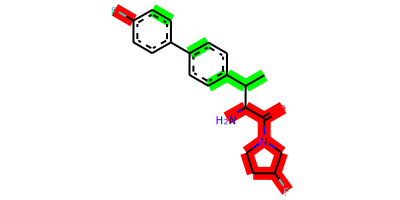

In [28]:
mol = MolFromSmiles("CC(C(N)C(=O)N1CCC(F)C1)C1=CC=C(C=C1)C1=CC=C(F)C=C1")  # 1.1um
_, img, _, _, global_importance = molecule_importance(mol,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-4,
                                                      addHs=False)
print(predict_mol(mol, model))
img

tensor([4.8391], grad_fn=<SelectBackward>)


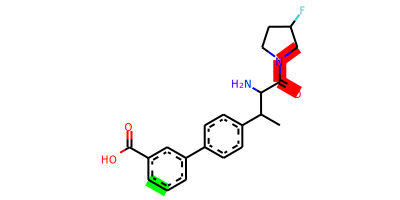

In [29]:
mol = MolFromSmiles("CC(C(N)C(=O)N1CCC(F)C1)C1=CC=C(C=C1)C1=CC=CC(=C1)C(O)=O")  # change decreases aff. to 100um
_, img, _, _, global_importance = molecule_importance(mol,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-3,
                                                      addHs=False)
print(predict_mol(mol, model))
img

tensor([4.6637], grad_fn=<SelectBackward>)


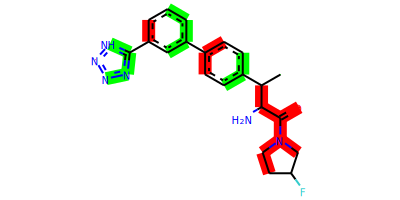

In [30]:
mol = MolFromSmiles("CC(C(N)C(=O)N1CCC(F)C1)C1=CC=C(C=C1)C1=CC=CC(=C1)C1=NN=NN1")  # change decreases aff. to 59um
_, img, _, _, global_importance = molecule_importance(mol,
                                                      model,
                                                      task=0,
                                                      version=3,
                                                      vis_factor=1,
                                                      eps=1e-4,
                                                      addHs=False)
print(predict_mol(mol, model))
img

### More examples from the publication (shown w/o code)
<br>
A potential "Activity Cliff" was used as selection criterion for these examples
<br>
<br>
<center>
<img width="80%" height="80%" src="pictures/xai.Figure7.png">
</center>

### Limitations
(copy/paste from the paper)

- First, the proposed methodology suffers from multicollinearity, meaning that it is unable to correctly assign importance values to a pair of strongly correlated molecular features. This issue is not exclusive to this particular methodology but is a limitation of many machine-learning approaches.
- Second, while we have shown that the described approach can successfully identify some structure−property relationships, either in the form of known motifs or property cliffs, several examples also exhibited some degree of attribution instability between closely related pair of compounds, which debatably could be due to insufficient training data, or a direct consequence of the Clever Hans effect, among other reasons.
-Third, this study would have benefited from a suitable XAI benchmark. Although several chemical series were provided to qualitatively evaluate the developed approach, the lack of suitable quantitative evaluation sets for XAI in chemistry and cheminformatics renders the evaluation of newly developed approaches arduous.

### Any other approaches?

**Sheridan** 
https://doi.org/10.1021/acs.jcim.8b00825
<br><br>
To highlight the importance of a particular atom, this approach iteratively “masks” individual atoms and computes a molecular fingerprint. These fingerprints are then combined with a machine-learning model, and the difference between the model prediction with and without masked atoms serves as a proxy for atom importance.

### Sheridan approach as implemented in the XAI paper
<br><br>
<center>
<img width="80%" height="80%" src="pictures/xai.Sheridan.png">
</center>
<br>
Figure 8 shows molecular structures for which the fingerprint-based model identified motifs corresponding to known pharmacophores of the hERG and CYP3A4 endpoints, using a well-known and robust industry standard, a random forest model with 1000 trees and ECFP4 fingerprinting featurization. Surprisingly, Figure 8a displays a bioisosteric ring substitution, involving the replacement of a pyrimidine with a thiazole, which in turn increases overall molecular weight and solubility, factors linked toward increased hERG inhibition. Figure 8b features a heme- binding group replacement example. Interestingly, the gradient-based approach proposed in this work failed for these presented examples, whereas the fingerprint-based approach was unable to reproduce any of the other coloring examples presented in this study (Figures 4−7), suggesting that their appropriateness may be case-dependent.

### Another visualisation approach

**Bajorath et al.** http://dx.doi.org/10.1021/acs.jmedchem.9b01101
<br><br>
<center>
<img width="77%" height="77%" src="pictures/xai.Bajorath.png">
</center>

### My two cents

- We are in need of supplementing ML  with such explainability
- XAI looks like a really interesting approach
- Fully agree that benchmarking is missing
- Is interpretability more/equal important to model performance?